<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Внимание!" data-toc-modified-id="Внимание!-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Внимание!</a></span></li><li><span><a href="#Установка-и-импорт-библиотек-для-обучения" data-toc-modified-id="Установка-и-импорт-библиотек-для-обучения-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Установка и импорт библиотек для обучения</a></span></li><li><span><a href="#Определение-словаря-для-токенизатора" data-toc-modified-id="Определение-словаря-для-токенизатора-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Определение словаря для токенизатора</a></span></li><li><span><a href="#Определение-основных-классов,-необходимых-для-обучения" data-toc-modified-id="Определение-основных-классов,-необходимых-для-обучения-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Определение основных классов, необходимых для обучения</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Конвертация-в-onnx-формат" data-toc-modified-id="Конвертация-в-onnx-формат-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Конвертация в onnx формат</a></span></li><li><span><a href="#Динамическая-квантизация-onnx-модели" data-toc-modified-id="Динамическая-квантизация-onnx-модели-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Динамическая квантизация onnx модели</a></span></li><li><span><a href="#Дополнительное-ускорение-инференса-модели" data-toc-modified-id="Дополнительное-ускорение-инференса-модели-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Дополнительное ускорение инференса модели</a></span><ul class="toc-item"><li><span><a href="#Инференс" data-toc-modified-id="Инференс-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Инференс</a></span></li></ul></li><li><span><a href="#Загрузка-модели-на-Hugginface" data-toc-modified-id="Загрузка-модели-на-Hugginface-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Загрузка модели на Hugginface</a></span></li><li><span><a href="#Инференс-onnx-модели" data-toc-modified-id="Инференс-onnx-модели-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Инференс onnx модели</a></span><ul class="toc-item"><li><span><a href="#Сабмит-в-нужной-форме" data-toc-modified-id="Сабмит-в-нужной-форме-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Сабмит в нужной форме</a></span></li></ul></li></ul></div>

# Внимание!

<font color="red" size=5> Обучение модели, инференс onnx модели происходили на google colab</font>

# Установка и импорт библиотек для обучения

In [ ]:
!pip install jiwer -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.6 MB/s eta 0:00:00


In [ ]:
import librosa
import pandas as pd
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor
from IPython.display import Audio
import torchaudio
import jiwer
from accelerate import Accelerator
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import os
import json
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Union

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #данные хранил на гугл диске для удобства:)

Mounted at /content/drive


Распаковка данных

P.S.
Просим прощения за длинный и неинформативный вывод в ноутбуке

In [ ]:
!unzip /content/drive/MyDrive/aug.zip -d /content/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/aug/4e7e0225-76fe-11ee-8d64-c09bf4619c03.wav  
  inflating: /content/aug/4e7e940a-76fe-11ee-bf8d-c09bf4619c03.wav  
  inflating: /content/aug/4e7efe8e-76fe-11ee-b67f-c09bf4619c03.wav  
  inflating: /content/aug/4e825bea-76fe-11ee-adbc-c09bf4619c03.wav  
  inflating: /content/aug/4e874bd6-76fe-11ee-85e3-c09bf4619c03.wav  
  inflating: /content/aug/4e8910ba-76fe-11ee-ab49-c09bf4619c03.wav  
  inflating: /content/aug/4e8a1233-76fe-11ee-bc36-c09bf4619c03.wav  
  inflating: /content/aug/4e8aa119-76ff-11ee-ae73-c09bf4619c03.wav  
  inflating: /content/aug/4e9fe761-76ff-11ee-a07e-c09bf4619c03.wav  
  inflating: /content/aug/4ea2ebfb-76fe-11ee-8e87-c09bf4619c03.wav  
  inflating: /content/aug/4eb2a8d5-76ff-11ee-8cb9-c09bf4619c03.wav  
  inflating: /content/aug/4eb7b879-76fe-11ee-98b8-c09bf4619c03.wav  
  inflating: /content/aug/4ec57a82-76ff-11ee-a34f-c09bf4619c03.wav  
  inflating: /content/aug/4ecbdd8e-

# Определение словаря для токенизатора

In [ ]:
data = pd.read_csv("full_json.csv")
data.head(3)

In [ ]:
all_chars = list("АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ ".lower())
print(len(all_chars))

vocab = {v: k for k, v in enumerate(all_chars)}

vocab["|"] = vocab[" "]
del vocab[" "]


vocab["[UNK]"] = len(vocab)
vocab["[PAD]"] = len(vocab)

print(vocab)
print(len(vocab))

In [ ]:
with open("vocab.json", "w", encoding="utf") as f:
    json.dump(vocab, f)

# Определение основных классов, необходимых для обучения

In [ ]:
tokenizer = Wav2Vec2CTCTokenizer(
    vocab_file="vocab.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    word_delimiter_token="|",
)
extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16_000,
    do_normalize=True,
    padding_value=0.0,
    return_attention_mask=False,
)
processor = Wav2Vec2Processor(
    feature_extractor=extractor,
    tokenizer=tokenizer,
)

In [ ]:
class RZHDDataset(Dataset):
    def __init__(
        self,
        path_to_full_jsonfile,
        dir_wth_files,
        tokenizer,
        extractor,
        processor,
        indexes=None
    ):
        super().__init__()
        self.df = pd.read_csv(path_to_full_jsonfile)
        self.df["audio_filepath"] = self.df["audio_filepath"].apply(
            lambda x: x.split('.')[0] + '.wav' if "mp3" in x else x
        )
        self.dir_files = dir_wth_files
        if indexes:
            self.df = self.df.loc[indexes]
            self.df.reset_index(drop=True, inplace=True)
        self.tokenizer = tokenizer
        self.extractor = extractor
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def _load_sample(self, file):
        arr, sr = librosa.load(file, sr=16_000, mono=True)
        return (arr, sr)

    def __getitem__(self, idx):
        sample = self.df.loc[idx]
        file = sample["audio_filepath"]
        text = sample["text"]
        label = sample["label"]
        attribute = sample["attribute"]

        arr, sr = self._load_sample(os.path.join(self.dir_files, file))

        labels = self.processor(text=text)
        inputs = self.processor(arr, sampling_rate=sr)

        return {
            "file": file,
            "array": arr,
            "sampling_rate": sr,
            "text": text,
            "label": label,
            "attribute": attribute,
            "input_values": inputs["input_values"][0],
            "labels": labels["input_ids"],
        }

In [ ]:
t = RZHDDataset("full_json.csv", "aug", tokenizer=tokenizer, extractor=extractor, processor=processor)
t.__len__()

In [ ]:
@dataclass
class DataCollatorCTCWithPadding:

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
loader = DataLoader(t, batch_size=4, collate_fn=data_collator)

In [ ]:
next(iter(loader))

In [ ]:
preds = processor.batch_decode(processor(text="подъём на пятый путь")["input_ids"], group_tokens=False)
for i, v in enumerate(preds):
    if v == '':
        preds[i] = ' '
''.join(preds)

# Обучение модели

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Название модели для тюнинга - это модель с первого этапа тюнинга (доступка на hugginface)

In [ ]:
MODEL_CHECKPOINT = "victor233/my_awesome_asr_mind_model"

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained(
    MODEL_CHECKPOINT,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

In [ ]:
model = model.to("cuda")

In [ ]:
model.freeze_feature_extractor()

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCTC, TrainingArguments, Trainer
import jiwer
from tqdm import tqdm

train_data, test_data = train_test_split(t, test_size=0.2, random_state=42)  # 80% для обучения, 20% для тестирования

# Создаем DataLoader для обучающей и тестовой выборок
train_loader = DataLoader(train_data, batch_size=4, collate_fn=data_collator)
test_loader = DataLoader(test_data, batch_size=4, collate_fn=data_collator)

# Функция для вычисления метрик
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = jiwer.wer(reference=label_str, hypothesis=pred_str)
    return {"wer": wer}


In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_asr_mind_modelv2",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,  # Обычно увеличивают при большом количестве шагов
    num_train_epochs=20,  # Задаем количество эпох
    gradient_checkpointing=True,
    fp16=True,
    group_by_length=True,
    eval_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=100,  # Частота сохранения модели
    eval_steps=100,  # Частота оценки
    logging_steps=5,  # Логирование лосса каждые 5 шагов
    load_best_model_at_end=True,
    metric_for_best_model="wer",  # Word Error Rate как основная метрика
    greater_is_better=False,
    push_to_hub=True,
)

# Создание экземпляра Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,  # Используем сами данные, а не DataLoader
    eval_dataset=test_data,  # Используем сами данные, а не DataLoader
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # Использование вашей функции метрики
)

# Запуск обучения
trainer.train()

In [ ]:
trainer.push_to_hub() #push model на HF

# Конвертация в onnx формат

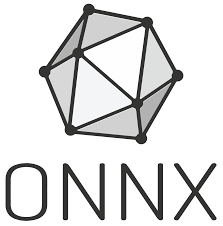

Обернем все в onnx для сжатия наших моделей

In [ ]:
!pip install noisereduce  onnx  onnxruntime  rapidfuzz -qU
!pip install optimum[exporters] -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00


In [ ]:
_label2id = {
    "отказ": 0,
    "отмена": 1,
    "подтверждение": 2,
    "начать осаживание": 3,
    "осадить на (количество) вагон": 4,
    "продолжаем осаживание": 5,
    "зарядка тормозной магистрали": 6,
    "вышел из межвагонного пространства": 7,
    "продолжаем роспуск": 8,
    "растянуть автосцепки": 9,
    "протянуть на (количество) вагон": 10,
    "отцепка": 11,
    "назад на башмак": 12,
    "захожу в межвагонное,пространство": 13,
    "остановка": 14,
    "вперед на башмак": 15,
    "сжать автосцепки": 16,
    "назад с башмака": 17,
    "тише": 18,
    "вперед с башмака": 19,
    "прекратить зарядку тормозной магистрали": 20,
    "тормозить": 21,
    "отпустить": 22,
}

In [ ]:
refs = tuple(_label2id.keys())

конвертация в onnx

In [ ]:
!optimum-cli export onnx --model vicot2/my_awesome_asr_mind_modelv2 content/

vicot2/my_awesome_asr_mind_modelv2 - путь к вашей новой модели на HF,
content/ -куда вы хотите сохранить модель в формате onnx

# Динамическая квантизация onnx модели

In [ ]:
import onnxruntime as ort
from transformers import Wav2Vec2Processor
from onnxruntime.quantization import quantize_dynamic, QuantType

def quantize_onnx_model(onnx_model_path, quantized_model_path):
    print("Starting quantization...")
    quantize_dynamic(onnx_model_path,
                     quantized_model_path,
                     weight_type=QuantType.QUInt8)  # Квантизация весов модели в QUInt8, так как процессор пульта поддерживает INT8 (ARM архитектура)

model_dir = "/content/content"
processor = Wav2Vec2Processor.from_pretrained(model_dir)
onnx_model_path = f"{model_dir}/model.onnx"
quantized_model_path = f"{model_dir}/quantized_model.onnx"

quantize_onnx_model(onnx_model_path, quantized_model_path)


# Дополнительное ускорение инференса модели

Для быстрого инференса (работает пока только в colab)

In [ ]:
!pip install -U flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash-attn


## Инференс

In [ ]:
FILE = r"/content/aug/2d645adb-76fe-11ee-99b2-c09bf4619c03.wav"

In [ ]:
import time
import numpy as np
import librosa
import onnxruntime as rt
from transformers import Wav2Vec2Processor
import noisereduce as nr
from rapidfuzz import process, utils, distance
from tqdm import tqdm

model_dir = "/content/drive/MyDrive/content" #директория с моделью
processor = Wav2Vec2Processor.from_pretrained(
    model_dir
    use_fast=True,
    torch_dtype=torch.float16,
    attn_implementation= "flash_attention_2"
) #ускоряем инференс нашей модели МАКСИМАЛЬНО
onnx_model_path = f"{model_dir}/quantized_model.onnx" #берем нашу квант+onnx модель

#Ниже код чисто для ускорения onnx на процессоре
sess_options = rt.SessionOptions()
sess_options.intra_op_num_threads = 4  # Количество потоков для выполнения операций
sess_options.inter_op_num_threads = 2  # Количество потоков для параллельного выполнения между операциями
sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_EXTENDED  # Максимальная оптимизация графа

ort_session = rt.InferenceSession(onnx_model_path, sess_options=sess_options)

In [ ]:
start_time = time.time()
arr, sr = librosa.load(FILE, sr=16_000, mono=True)
reduced_noise = nr.reduce_noise(y=arr, sr=sr, n_jobs=-1, device="cpu")

energy_threshold = 0.4
window_size = 8
idx = []

for i in tqdm(range(0, len(reduced_noise), window_size)):
    en = np.sum(np.abs(reduced_noise[i:i+window_size]**2))
    if en > energy_threshold:
        idx.append([i, i+window_size])

if len(idx) > 0:
    arr = reduced_noise[idx[0][0]:idx[0][1]]
    for i in idx[1:]:
        arr = np.hstack([arr, reduced_noise[i[0]:i[1]]])

inputs = processor(arr, sampling_rate=16_000, return_tensors="np", padding=True)

ort_inputs = {"input_values": inputs.input_values}
logits = ort_session.run(None, ort_inputs)[0]
predicted_ids = np.argmax(logits, axis=-1)
predicted_sentences = processor.batch_decode(predicted_ids)

sent = predicted_sentences[0]

r = process.extract(sent, refs, scorer=distance.Levenshtein.normalized_similarity, processor=utils.default_process)

end_time = time.time()
print(f"Результат сопоставления: {r[0]}")
print(f"Время инференса: {end_time - start_time:.4f} секунд")

# Загрузка модели на Hugginface

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import HfApi, HfFolder, create_repo
import os

# Укажите путь к вашей модели и имя вашего репозитория
model_dir = "/content/drive/MyDrive/content"  # Папка с вашей моделью
repo_id = "vicot2/my_awesome_asr_mind_modelv3"  # Замените на ваше имя пользователя и название репозитория

# Авторизация (если требуется)
HfFolder.save_token("token")  # Замените на ваш токен

# Создание репозитория
create_repo(repo_id=repo_id, exist_ok=True)

# Загрузка всех файлов из указанной папки
api = HfApi()

for filename in os.listdir(model_dir):
    file_path = os.path.join(model_dir, filename)

    if os.path.isfile(file_path):
        # Загрузка файла в репозиторий
        api.upload_file(
            path_or_fileobj=file_path,
            path_in_repo=filename,  # Имя файла в репозитории
            repo_id=repo_id,
            commit_message=f"Upload {filename}"
        )

model.onnx:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


# Инференс onnx модели

In [27]:
import time
import numpy as np
import librosa
import onnxruntime as rt
from transformers import Wav2Vec2Processor
import noisereduce as nr
from rapidfuzz import process, utils, distance
from tqdm import tqdm
import torch
import os
from NumExtractor.extractor import NumberExtractor

In [17]:
_label2id = {
    "отказ": 0,
    "отмена": 1,
    "подтверждение": 2,
    "начать осаживание": 3,
    "осадить на (количество) вагон": 4,
    "продолжаем осаживание": 5,
    "зарядка тормозной магистрали": 6,
    "вышел из межвагонного пространства": 7,
    "продолжаем роспуск": 8,
    "растянуть автосцепки": 9,
    "протянуть на (количество) вагон": 10,
    "отцепка": 11,
    "назад на башмак": 12,
    "захожу в межвагонное,пространство": 13,
    "остановка": 14,
    "вперед на башмак": 15,
    "сжать автосцепки": 16,
    "назад с башмака": 17,
    "тише": 18,
    "вперед с башмака": 19,
    "прекратить зарядку тормозной магистрали": 20,
    "тормозить": 21,
    "отпустить": 22,
}

refs = tuple(_label2id.keys())

In [6]:
MODEL_DIR = "onnx_weights"

<font color='red' size=4>веса onnx модели обязательно должны лежать в папке onnx_weights</font>

In [7]:
processor = Wav2Vec2Processor.from_pretrained(
    MODEL_DIR,
    use_fast=True,
    torch_dtype=torch.float16,
    attn_implementation= "flash_attention_2"
) #ускоряем инференс нашей модели МАКСИМАЛЬНО
onnx_model_path = f"{MODEL_DIR}/quantized_model.onnx" #берем нашу квант+onnx модель

#Ниже код чисто для ускорения onnx на процессоре
sess_options = rt.SessionOptions()
sess_options.intra_op_num_threads = 4  # Количество потоков для выполнения операций
sess_options.inter_op_num_threads = 2  # Количество потоков для параллельного выполнения между операциями
sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_EXTENDED  # Максимальная оптимизация графа

ort_session = rt.InferenceSession(onnx_model_path, sess_options=sess_options)

In [15]:
def estimate_energy(arr, threshold=0.2, frame_len=1600):
    lst = list()
    for i in range(0, len(arr), frame_len):
        en = np.sum(np.abs(arr[i:i+frame_len]**2))
        if en > threshold:
            lst.append(arr[i:i+frame_len])
    return np.concatenate(lst)

In [13]:
FILE = r".\train_dataset\luga\02_11_2023\2023_11_02__10_32_31.wav"

In [18]:
start_time = time.time()
arr, sr = librosa.load(FILE, sr=16_000, mono=True)
arr = arr[8_000:-8_000]
reduced_noise = nr.reduce_noise(
    y=arr, sr=sr, n_jobs=-1, device="cpu", win_length=512,
    use_torch=False, stationary=False, 
    time_constant_s=1.0,
    time_mask_smooth_ms=100,
    hop_length=256, # 128
    n_fft=512,
    freq_mask_smooth_hz=1024,
    thresh_n_mult_nonstationary=2.5,
)

audio_array = estimate_energy(reduced_noise, frame_len=1_600)

inputs = processor(arr, sampling_rate=16_000, return_tensors="np", padding=True)

ort_inputs = {"input_values": inputs.input_values}
logits = ort_session.run(None, ort_inputs)[0]

predicted_ids = np.argmax(logits, axis=-1)
predicted_sentences = processor.batch_decode(predicted_ids)

sent = predicted_sentences[0]

r = process.extract(sent, refs, scorer=distance.Levenshtein.normalized_similarity, processor=utils.default_process)

end_time = time.time()
print(f"Результат сопоставления: {r[0]}")
print(f"Время инференса: {end_time - start_time:.4f} секунд")

Результат сопоставления: ('вперед на башмак', 0.75, 15)
Время инференса: 0.5709 секунд


## Сабмит в нужной форме

In [29]:
extractor = NumberExtractor()

label = _label2id[r[0][0]]
attr = -1
if label in [4, 10]:
    try:
        attr = int(
            tuple(
                filter(
                    lambda x: x.isnumeric(),
                    extractor.replace_groups(sent).split(' ')
                )
            )[0]
        )
    except:
        pass

submit = {
    "audio": os.path.split(FILE)[-1],
    "text": sent,
    "label": label,
    "attribute": -1,
}

submit

{'audio': '2023_11_02__10_32_31.wav',
 'text': 'впед на вашмк',
 'label': 15,
 'attribute': -1}